# Laboratorio 5 - Minería de Textos y Análisis de Sentimientos

### Sebastian Juarez - 21471
### Juan Pablo Cordón - 21458

Link al repositorio de Github: https://github.com/SebasJuarez/DS-Collection/tree/Lab5

## Avances

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Data/train.csv")

print(df.shape)
df.head()


(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


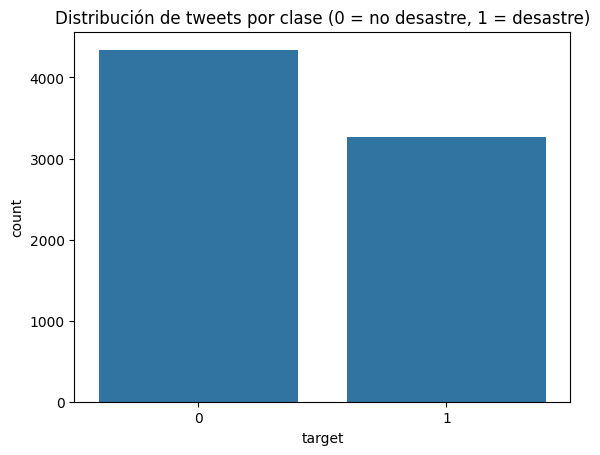

target
0    57.034021
1    42.965979
Name: proportion, dtype: float64

In [46]:
df.info()

df.isnull().sum()

sns.countplot(x="target", data=df)
plt.title("Distribución de tweets por clase (0 = no desastre, 1 = desastre)")
plt.show()

df["target"].value_counts(normalize=True) * 100


In [47]:
# Ver ejemplos de números en los tuits para ver como manejarlos
with_numbers = df[df["text"].str.contains("\d")]
# Mostrar ejemplos
for i in range(30):
    print(with_numbers.iloc[i]["text"])

13,000 people receive #wildfires evacuation orders in California 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 
Damage to school bus on 80 in multi car crash #BREAKING 
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi
On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N
INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA
Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX


### Limpieza de los datos

In [48]:
import re
import string

# ——— Utilidades ———
URL_PATTERN = r"http\S+|www\S+|https\S+"
# Emoticones básicos -> etiquetas (puedes ampliar)
EMO_POS = {":)", ";)", ":d", "xd", ":p", ":3"}
EMO_NEG = {":(", ":'(", ">:(", ":'c"}

NEGATION_WORDS = r"\b(no|not|never|n't|cannot|can't|won't|don't|didn't|isn't|aren't|ain't)\b"

def clean_text(text):
    # 0) Normalizar a str
    text = "" if text is None else str(text)

    # 1) Quitar solo URLs (VADER se beneficia de conservar puntuación/emociones)
    text = re.sub(URL_PATTERN, " ", text)

    # 2) Extraer hashtags (sin #) y emoticones (case-insensitive)
    hashtags = re.findall(r"#(\w+)", text, flags=re.IGNORECASE)

    # Para emoticones, trabajamos en versión minúscula para buscar
    low = text.lower()
    emoticons_found = []
    for emo in EMO_POS | EMO_NEG:
        if emo in low:
            emoticons_found.append(emo)

    # 3) Señales de énfasis: exclamaciones/preguntas/mayúsculas
    #    - Contamos rachas de ! y ? y las mapeamos a tokens (máximo 3)
    excl_runs = re.findall(r"!+", text)
    ques_runs = re.findall(r"\?+", text)
    n_excl = min(3, sum(len(r) for r in excl_runs))  # total de "!" cap a 3
    n_ques = min(3, sum(len(r) for r in ques_runs))  # total de "?" cap a 3

    # Palabras EN MAYÚSCULAS (>= 3 letras) => señal de énfasis
    words = re.findall(r"[A-Za-z]+", text)
    has_allcaps = any(w.isupper() and len(w) >= 3 for w in words)

    # 4) Limpiar preservando negaciones y !?
    #    - Quitamos puntuación excepto ! ? y apóstrofo (para "don't", "can't")
    punct_to_remove = "".join(ch for ch in string.punctuation if ch not in "!?'")
    text = text.translate(str.maketrans('', '', punct_to_remove))

    # 5) Normalizaciones léxicas específicas
    #    - Mantener negaciones como token "NEG" antes de bajar a minúsculas
    text = re.sub(NEGATION_WORDS, r" \1 NEG ", text, flags=re.IGNORECASE)

    #    - Números: removemos todo salvo "911" => "nine eleven"
    text = re.sub(r"\b\d+\b(?!\s*911)", " ", text)
    text = text.replace("911", "nine eleven")

    #    - Quitar caracteres no ASCII raros
    text = re.sub(r"[^\x00-\x7F]+", " ", text)

    # 6) Bajar a minúsculas al final (tras inyectar NEG)
    text = text.lower()

    # 7) Inyectar tokens de señales de énfasis
    #    (esto queda en el texto y lo captará tu vectorizador)
    if has_allcaps:
        text += " ALLCAPS"
    text += " " + " EXCL" * n_excl
    text += " " + " QUES" * n_ques

    # 8) Mapear emoticones a tokens (mantener conteo semántico)
    if any(emo in low for emo in EMO_POS):
        text += " EMO_POS"
    if any(emo in low for emo in EMO_NEG):
        text += " EMO_NEG"

    # 9) Eliminar restos de # y @ (si quedaron), y espacios extra
    text = re.sub(r"[@#]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Regresa mismo contrato: (texto_enriquecido, hashtags, emoticons_encontrados)
    return text, hashtags, emoticons_found

# Aplicación (igual que antes)
df["clean_text"], df["hashtags"], df["emoticons"] = zip(*df["text"].apply(clean_text))


<Axes: >

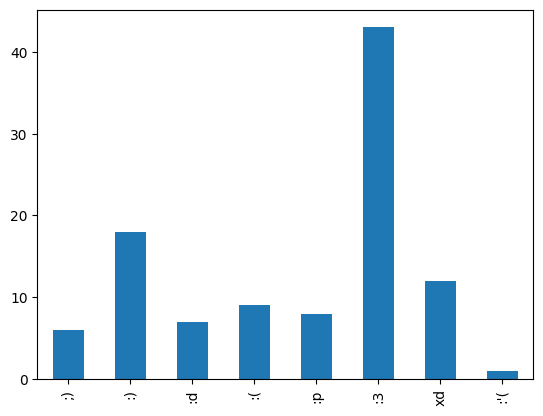

In [49]:
# Emoticon counts
df["emoticons"].apply(lambda x: pd.Series(1, index=x)).fillna(0).sum().plot(kind='bar')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


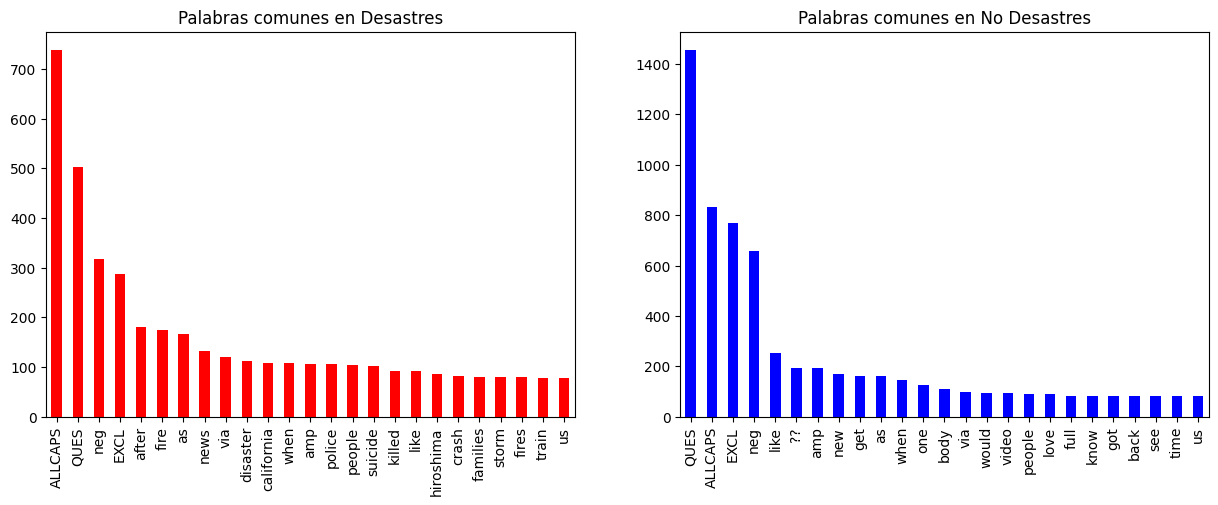

In [50]:
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")
stopwords = set(stopwords.words("english"))
# Leave words that might be useful
stopwords = stopwords - set(["when", "while", "once", "during", "after", "before", "until", "as", "because"])

# Eliminar palabras vacías, stopwords, preposiciones, etc.
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

df["clean_text"] = df["clean_text"].apply(remove_stopwords)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
df[df["target"] == 1]["clean_text"].str.split(expand=True).stack().value_counts().head(25).plot(kind='bar', color='red')
plt.title("Palabras comunes en Desastres")

plt.subplot(1, 2, 2)
df[df["target"] == 0]["clean_text"].str.split(expand=True).stack().value_counts().head(25).plot(kind='bar', color='blue')
plt.title("Palabras comunes en No Desastres")

plt.show()


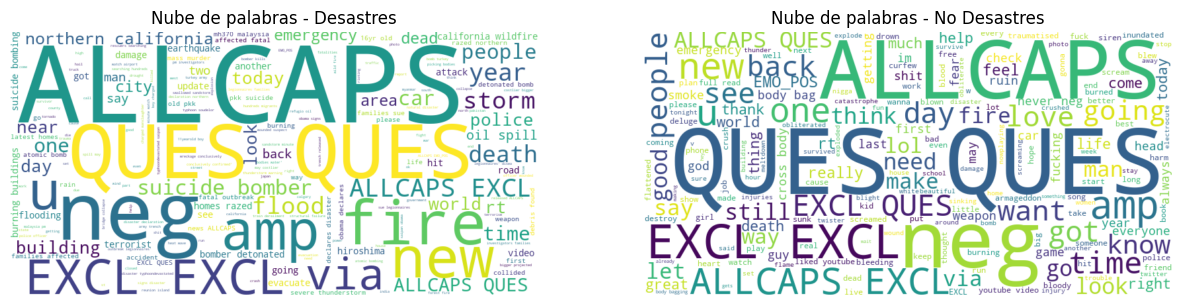

In [51]:
# Hacer un wordcloud de las palabras comunes en desastres y en no desastres
from wordcloud import WordCloud

nube_desastre = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df["target"] == 1]["clean_text"]))

nube_no_desastre = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df[df["target"] == 0]["clean_text"]))

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(nube_desastre, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Desastres")

plt.subplot(1, 2, 2)
plt.imshow(nube_no_desastre, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - No Desastres")

plt.show()

### Inicio de tokenización

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_vectorizer = CountVectorizer(max_features=5000, stop_words="english")
X_bow = bow_vectorizer.fit_transform(df["clean_text"])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])

print("Shape BoW:", X_bow.shape)
print("Shape TF-IDF:", X_tfidf.shape)


Shape BoW: (7613, 5000)
Shape TF-IDF: (7613, 5000)


In [ ]:
# Mas imports de cosas

import warnings, os, sys, re, string, math, json, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, f1_score, roc_auc_score, roc_curve)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


In [ ]:
# N-gramas
def top_ngrams(corpus, n=20, ngram_range=(1,2)):
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range, min_df=2)
    X = vec.fit_transform(corpus)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top_idx = np.argsort(freqs)[::-1][:n]
    return pd.DataFrame({"ngram": vocab[top_idx], "freq": freqs[top_idx]})

top1 = top_ngrams(df.loc[df.target==1,"clean_text"], n=25)
top0 = top_ngrams(df.loc[df.target==0,"clean_text"], n=25)

display(top1.head(10))
display(top0.head(10))


,ngram,freq
0,allcaps,738
1,ques,503
2,neg,317
3,excl,287
4,ques ques,212
5,news,136
6,disaster,118
7,california,115
8,suicide,110
9,amp,108


,ngram,freq
0,ques,1455
1,allcaps,831
2,excl,770
3,ques ques,705
4,neg,658
5,like,253
6,excl excl,248
7,amp,192
8,new,171
9,allcaps excl,137


In [ ]:
# División de los datos
X = df["clean_text"].values
y = df["target"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
pipe_base = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english")),
    ("clf", baseline)
])
pipe_base.fit(X_train, y_train)
pred_base = pipe_base.predict(X_valid)
print("Baseline acc:", accuracy_score(y_valid, pred_base),
      "F1:", f1_score(y_valid, pred_base))


Baseline acc: 0.5705843729481287 F1: 0.0


### Entrenamiento de modelos

In [ ]:
# Entrenamos los diferentes modelos
def make_pipeline(model):
    return Pipeline([
        ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english",
                                  sublinear_tf=True)),
        ("clf", model)
    ])

models = {
    "LogReg": LogisticRegression(max_iter=300, n_jobs=None, random_state=RANDOM_STATE),
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC(random_state=RANDOM_STATE)
}

results = []
for name, clf in models.items():
    pipe = make_pipeline(clf)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    f1 = cross_val_score(pipe, X, y, scoring="f1", cv=skf, n_jobs=-1)
    acc = cross_val_score(pipe, X, y, scoring="accuracy", cv=skf, n_jobs=-1)
    results.append({"modelo": name, "f1_mean": f1.mean(), "f1_std": f1.std(), 
                    "acc_mean": acc.mean(), "acc_std": acc.std()})
    
res_df = pd.DataFrame(results).sort_values("f1_mean", ascending=False)
res_df


,modelo,f1_mean,f1_std,acc_mean,acc_std
0,LogReg,0.744932,0.015634,0.803627,0.012251
2,LinearSVC,0.744703,0.011048,0.791016,0.009905
1,MultinomialNB,0.729297,0.018080,0.797848,0.013648


Mejor modelo por F1: LogReg
Accuracy: 0.8187787261982928
F1: 0.7673

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.7992    0.9114    0.8516       869
           1     0.8553    0.6957    0.7673       654

    accuracy                         0.8188      1523
   macro avg     0.8272    0.8036    0.8094      1523
weighted avg     0.8233    0.8188    0.8154      1523



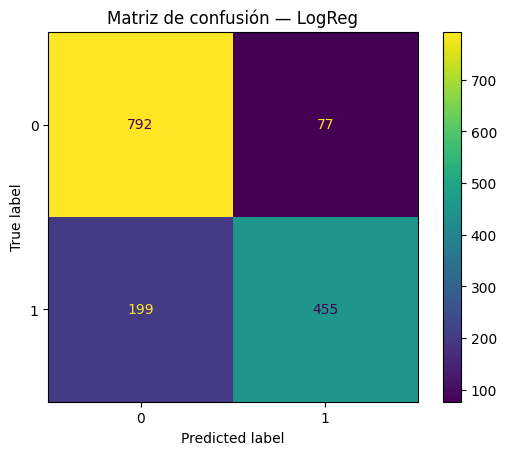

In [ ]:
# Mejor modelo basado en los resultados
best_name = res_df.iloc[0]["modelo"]
print("Mejor modelo por F1:", best_name)

best_clf = models[best_name]
best_pipe = make_pipeline(best_clf)
best_pipe.fit(X_train, y_train)

pred = best_pipe.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, pred))
print("F1:", f1_score(y_valid, pred).round(4))
print("\nReporte de clasificación:\n", classification_report(y_valid, pred, digits=4))

cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format="d"); plt.title(f"Matriz de confusión — {best_name}")
plt.show()


In [ ]:
# Tipos de Desastres

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english", sublinear_tf=True)
X_tr = tfidf.fit_transform(X_train)

if best_name in ["LogReg", "MultinomialNB"]:
    clf = models[best_name]
    clf.fit(X_tr, y_train)
    feature_names = np.array(tfidf.get_feature_names_out())
    if best_name == "LogReg":
        coefs = clf.coef_[0]
    else: 
        coefs = clf.coef_[0]

    top_pos = feature_names[np.argsort(coefs)[-20:]][::-1]
    top_neg = feature_names[np.argsort(coefs)[:20]]

    print("Top términos clase 1 (desastre):")
    display(pd.DataFrame({"term": top_pos}))
    print("\nTop términos clase 0 (no desastre):")
    display(pd.DataFrame({"term": top_neg}))
else:
    print("Para LinearSVC, puedes usar coef_ similarmente si deseas:")
    svc = LinearSVC(random_state=RANDOM_STATE)
    svc.fit(X_tr, y_train)
    feature_names = np.array(tfidf.get_feature_names_out())
    coefs = svc.coef_[0]
    top_pos = feature_names[np.argsort(coefs)[-20:]][::-1]
    top_neg = feature_names[np.argsort(coefs)[:20]]
    print("Top términos clase 1 (desastre):")
    display(pd.DataFrame({"term": top_pos}))
    print("\nTop términos clase 0 (no desastre):")
    display(pd.DataFrame({"term": top_neg}))


Top términos clase 1 (desastre):


,term
0,hiroshima
1,california
2,fires
3,buildings
4,killed
5,storm
6,police
7,earthquake
8,wildfire
9,suicide



Top términos clase 0 (no desastre):


,term
0,ques
1,love
2,new
3,neg
4,excl
5,wrecked
6,let
7,body
8,bloody
9,ruin


In [59]:
# === Bloque 10: Ejemplos mal clasificados para comentario cualitativo ===
bad_idx = np.where(pred != y_valid)[0]
samples = pd.DataFrame({
    "text": np.array(X_valid)[bad_idx],
    "true": y_valid[bad_idx],
    "pred": pred[bad_idx]
})
samples.head(15)


,text,true,pred
0,theeconomist step one get mass murderer's portrait yuan,0,1
1,hollywood movie trapped miners released chile 'the ' hollywood movie trapped miners starring,1,0
2,thu aug gmt0000 utc millcityio theramin sirens ALLCAPS EMO_POS,1,0
3,can't neg drown demons know swim,1,0
4,xhnews need plants pacific during cyclone seasons would help,1,0
5,firefighters acted like cops drive around shooting flamethrower burning buildings,0,1
6,'it looks like mudslide' poor thing! ?? greatbritishbakeoff EXCL QUES QUES,1,0
7,bomb head? explosive decisions dat produced dead children dead bodies trapped tween buildings day september QUES,1,0
8,agree certain cultural appropriation things honestly u looked house screams appropriation bc buddhas stuff,1,0
9,dress memes officially exploded internet,1,0


### Guardamos el modelo para la funcion

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

if "clean_text" not in df.columns:
    df["clean_text"] = df["text"].apply(clean_text)

df["sentiment_scores"] = df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["negativity"] = -df["sentiment_scores"]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=25000, ngram_range=(1,2),
                                 stop_words="english", sublinear_tf=True),
         "clean_text"),
        ("neg", StandardScaler(with_mean=False), ["negativity"]),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

final_pipe_neg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
])

final_pipe_neg.fit(df[["clean_text", "negativity"]], df["target"])

import joblib, os
os.makedirs("artifacts", exist_ok=True)
joblib.dump(final_pipe_neg, "artifacts/tweet_classifier_with_neg.joblib")
print("✅ Guardado: artifacts/tweet_classifier_with_neg.joblib")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


✅ Guardado: artifacts/tweet_classifier_with_neg.joblib


### Funcion de tweets

In [ ]:
import joblib
import pandas as pd

modelo_neg = joblib.load("artifacts/tweet_classifier_with_neg.joblib")

def clasificar_tweet(tweet: str, return_proba: bool = True) -> str:
    texto_limpio, hashtags, emoticons = clean_text(tweet)

    # vemos la negatividad
    score = sia.polarity_scores(texto_limpio)["compound"]
    neg = -score

    X_infer = pd.DataFrame({"clean_text": [texto_limpio], "negativity": [neg]})

    # prediccion
    pred = modelo_neg.predict(X_infer)[0]
    etiqueta = "Desastre (1)" if pred == 1 else "No desastre (0)"

    if return_proba and hasattr(modelo_neg.named_steps["clf"], "predict_proba"):
        proba = modelo_neg.predict_proba(X_infer)[0, 1]
        return f"{etiqueta} | prob={proba:.3f} | neg={neg:.3f} | hashtags={len(hashtags)} | emoticons={len(emoticons)}"
    return f"{etiqueta} | neg={neg:.3f} | hashtags={len(hashtags)} | emoticons={len(emoticons)}"


In [ ]:
tests = [
    "Earthquake in Guatemala, thousands affected",
    "So happy to get coffee with friends!",
    "Massive wildfire spreading quickly, residents evacuated now",
    "The new phone looks amazing",
    "Catastrophic floods hit the coastal region, homes destroyed",
    "Great vibes at the beach today"
]

for t in tests:
    print(t)
    print(" ->", clasificar_tweet(t))
    print("-"*70)

Earthquake in Guatemala, thousands affected
 -> Desastre (1) | prob=0.761 | neg=0.153 | hashtags=0 | emoticons=0
----------------------------------------------------------------------
So happy to get coffee with friends!
 -> No desastre (0) | prob=0.104 | neg=-0.812 | hashtags=0 | emoticons=0
----------------------------------------------------------------------
Massive wildfire spreading quickly, residents evacuated now
 -> Desastre (1) | prob=0.831 | neg=-0.000 | hashtags=0 | emoticons=0
----------------------------------------------------------------------
The new phone looks amazing
 -> No desastre (0) | prob=0.106 | neg=-0.586 | hashtags=0 | emoticons=0
----------------------------------------------------------------------
Catastrophic floods hit the coastal region, homes destroyed
 -> Desastre (1) | prob=0.848 | neg=0.751 | hashtags=0 | emoticons=0
----------------------------------------------------------------------
Great vibes at the beach today
 -> No desastre (0) | prob=0.32

### Input del tweet

In [74]:
tweet= input("Escribe un tweet para clasificar: ")
print(clasificar_tweet(tweet))

Desastre (1) | prob=0.605 | neg=-0.000 | hashtags=0 | emoticons=0


### Analisis de Sentimiento

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

df["sentiment_scores"] = df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

def sentiment_label(score):
    if score >= 0.05:
        return "Positivo"
    elif score <= -0.05:
        return "Negativo"
    else:
        return "Neutro"

df["sentiment_label"] = df["sentiment_scores"].apply(sentiment_label)

df[["text", "sentiment_scores", "sentiment_label"]].head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,text,sentiment_scores,sentiment_label
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0.2732,Positivo
1,Forest fire near La Ronge Sask. Canada,-0.3400,Negativo
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0.0000,Neutro
3,"13,000 people receive #wildfires evacuation orders in California",0.0000,Neutro
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0.0000,Neutro
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,-0.3400,Negativo
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",-0.6249,Negativo
7,I'm on top of the hill and I can see a fire in the woods...,-0.1531,Negativo
8,There's an emergency evacuation happening now in the building across the street,-0.3818,Negativo
9,I'm afraid that the tornado is coming to our area...,0.0000,Neutro


In [ ]:
# Tops de sentimientos
top_neg = df.sort_values("sentiment_scores").head(10)[["text","target","sentiment_scores"]]
top_pos = df.sort_values("sentiment_scores", ascending=False).head(10)[["text","target","sentiment_scores"]]

print("=== 10 tweets más negativos ===")
display(top_neg)

print("=== 10 tweets más positivos ===")
display(top_pos)


=== 10 tweets más negativos ===


,text,target,sentiment_scores
7472,wreck? wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck?,0,-0.9883
6411,Suicide bomber kills 15 in Saudi security site mosque - A suicide bomber killed at least 15 people in an attack on... http://t.co/FY0r9o7Xsl,1,-0.9623
6393,? 19th Day Since 17-Jul-2015 -- Nigeria: Suicide Bomb Attacks Killed 64 People; Blamed: Boko Haram [L.A. Times/AP] | http://t.co/O2cdKpSDfp,1,-0.9595
6407,17 killed in SÛªArabia mosque suicide bombing\n\nA suicide bomber attacked a mosque in Aseer south-western Saudi... http://t.co/pMTQhiVsXX,1,-0.9552
2932,at the lake \n*sees a dead fish*\nme: poor little guy i wonder what happened\nashley: idk maybe it drowned\n wtf ????????,0,-0.9549
472,illegal alien released by Obama/DHS 4 times Charged With Rape &amp; Murder of Santa Maria CA Woman Had Prior Offenses http://t.co/MqP4hF9GpO,1,-0.9538
1540,Bomb Crash Loot Riot Emergency Pipe Bomb Nuclear Chemical Spill Gas Ricin Leak Violence Drugs Cartel Cocaine Marijuana Heroine Kidnap Bust,1,-0.9524
6930,@cspan #Prez. Mr. President you are the biggest terrorist and trouble maker in the world. You create terrorist you sponsor terrorist.,1,-0.9493
2844,@peterjukes A crime that killed/displaced millions. In which systematic torture was carried out. But look. GrahamWP fired a gun! Arrest him!,1,-0.9467
6818,Bomb head? Explosive decisions dat produced more dead children than dead bodies trapped tween buildings on that day in September there,1,-0.9451


=== 10 tweets más positivos ===


,text,target,sentiment_scores
6992,Check out 'Want Twister Tickets AND A VIP EXPERIENCE To See SHANIA? CLICK HERE:' at http://t.co/3GEROQ49o1\nI would Love Love Love!! To win,0,0.9705
3163,@batfanuk we enjoyed the show today. Great fun. The emergency non evacuation was interesting. Have a great run.,0,0.9423
3382,@batfanuk we enjoyed the show today. Great fun. The emergency non evacuation was interesting. Have a great run.,0,0.9423
6292,TodayÛªs storm will pass; let tomorrowÛªs light greet you with a kiss. Bask in this loving warmth; let your soul return to bliss.,1,0.9403
6295,Free Ebay Sniping RT? http://t.co/B231Ul1O1K Lumbar Extender Back Stretcher Excellent Condition!! ?Please Favorite &amp; Share,0,0.9376
7182,@RogueWatson Nothing wrong with that. The Lethal Weapon series is great. Yes they're ALL great.,0,0.9365
6560,@duchovbutt @Starbuck_Scully @MadMakNY @davidduchovny yeah we survived 9 seasons and 2 movies. Let's hope for the good. There's hope ??????,0,0.9344
2238,#MeditationByMSG 45600 ppl got method of meditation in U.P &amp;got deluge of divine blessing 4 happy n peaceful life. http://t.co/VMf5LnxVzC,0,0.9287
1856,Love love love do you remember your first crush ? ??,0,0.9266
7069,But...! Oh! \n\nHow rich the soil?!\n\nHow wonderful the upheaval!?\n\n-@ENTERSHIKARI,0,0.9257


Promedio de puntaje de sentimiento por categoría:
target
0   -0.057668
1   -0.269796
Name: sentiment_scores, dtype: float64


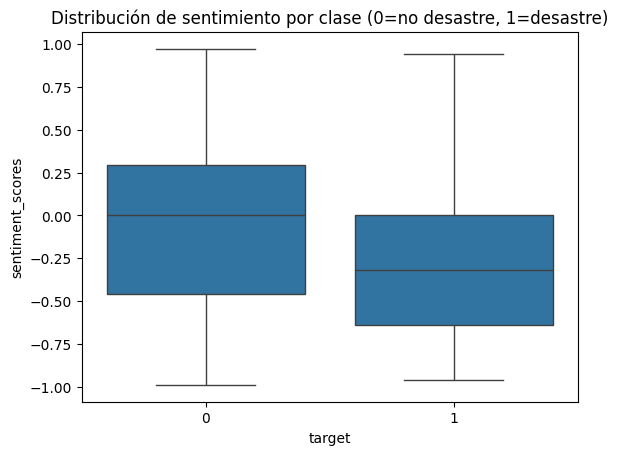

In [ ]:
# Comparamos negatividad
avg_sent = df.groupby("target")["sentiment_scores"].mean()
print("Promedio de puntaje de sentimiento por categoría:")
print(avg_sent)

sns.boxplot(x="target", y="sentiment_scores", data=df)
plt.title("Distribución de sentimiento por clase (0=no desastre, 1=desastre)")
plt.show()


### Reentrenamiento y resultados

In [ ]:
# Agregamos negatividad y reentrenamos
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

if "sentiment_scores" not in df.columns:
    import nltk
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk.download("vader_lexicon")
    sia = SentimentIntensityAnalyzer()
    df["sentiment_scores"] = df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

df["negativity"] = -df["sentiment_scores"]

X_df = df[["clean_text", "negativity"]].copy()
y = df["target"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X_df, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2),
                                  stop_words="english", sublinear_tf=True),
         "clean_text"),
        ("neg", StandardScaler(with_mean=False), ["negativity"])
    ],
    remainder="drop"
)

pipe_with_neg = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=400, random_state=RANDOM_STATE))
])

pipe_with_neg.fit(X_train, y_train)
pred_new = pipe_with_neg.predict(X_valid)

print("Accuracy (con negatividad):", round(accuracy_score(y_valid, pred_new), 4))
print("F1 (con negatividad):", round(f1_score(y_valid, pred_new), 4))

print("\nReporte con variable negatividad:\n",
      classification_report(y_valid, pred_new, digits=4))


Accuracy (con negatividad): 0.807
F1 (con negatividad): 0.7542

Reporte con variable negatividad:
               precision    recall  f1-score   support

           0     0.7931    0.8953    0.8411       869
           1     0.8321    0.6896    0.7542       654

    accuracy                         0.8070      1523
   macro avg     0.8126    0.7924    0.7976      1523
weighted avg     0.8098    0.8070    0.8038      1523

